#Exercise

Instead of using the MNIST dataset, train with the FASHION dataset.
Try both dense and convolutional GANs (the same as in the notebooks or by changing/adding layers and neurons) until achieving "visually acceptable" results.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

BATCH_SIZE = 512
random_normal_dimensions = 32

#Dense

In [ ]:
import os
print(os.listdir('/content/drive'))

['MyDrive']


In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


In [ ]:
def plot_images(images, epoch, col, row = 5):
    display.clear_output(wait=False)

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(col, row))
    plt.suptitle('Epoch: ' + str(epoch))

    for index, image in enumerate(images):
        plt.subplot(row, col, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        if index==24:
            break

## Loading Fashion Data

In [ ]:
(x_train, _), _ = keras.datasets.fashion_mnist.load_data() # I only need the images

x_train = x_train.astype(np.float32) / 255.

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(len(x_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

4422102/4422102 [==============================] - 0s 0us/step


## Generator

In [ ]:
generator = keras.models.Sequential([
    keras.layers.Dense(256, activation="selu", input_shape=[random_normal_dimensions]),
    keras.layers.Dense(512, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

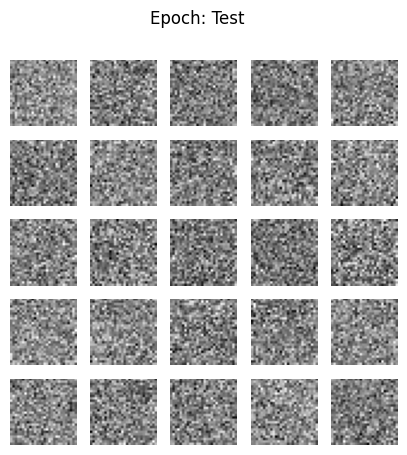

In [ ]:
test_noise = tf.random.normal([BATCH_SIZE, random_normal_dimensions]) # normal distributed error

test_image = generator(test_noise) # generation with the model

plot_images(test_image, 'Test', 5)

## Discriminator

In [ ]:
# build the discriminator model
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(256, activation="selu"),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

### GAN definition as the sequence generator + discriminator

In [ ]:
GAN = keras.models.Sequential([generator, discriminator])
GAN.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Function to generate it based on number of neurons per layer

In [ ]:
def dense_gan_creator(random_normal_dimensions, gen_params, image_shape, dis_params):

    inputsg = tf.keras.layers.Input(shape=[random_normal_dimensions])

    # Generador
    gen = tf.keras.layers.Dense(gen_params[0], activation="selu")(inputsg)
    gen = tf.keras.layers.Dense(gen_params[1], activation="selu")(gen)
    gen = tf.keras.layers.Dense(image_shape * image_shape, activation="sigmoid")(gen)
    gen = tf.keras.layers.Reshape([image_shape, image_shape])(gen)
    gen = tf.keras.layers.Dropout(0.4)(gen)  # Agregar capa Dropout

    generator = tf.keras.Model(inputs=inputsg, outputs=gen)

    # Discriminador
    dis = tf.keras.layers.Flatten(input_shape=[image_shape, image_shape])(gen)
    dis = tf.keras.layers.Dropout(0.4)(dis)  # Agregar capa Dropout
    dis = tf.keras.layers.Dense(dis_params[0], activation="selu")(dis)
    dis = tf.keras.layers.Dense(dis_params[1], activation="selu")(dis)
    dis = tf.keras.layers.Dense(1, activation="sigmoid")(dis)

    discriminator = tf.keras.Model(inputs=gen, outputs=dis)
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    discriminator.trainable = False

    gan = tf.keras.models.Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

    return gan

## Train the Model and save it to run it later

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, folder, n_epochs=50):

    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:

            ### -- PHASE 1 -- ####
            batch_size = real_images.shape[0]

            # generation of fake images
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)

            # generation of train batch images and ground truth for training the discriminator
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # 1 for real images

            # train the discriminator on the batch
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            discriminator.trainable = False

            ### -- PHASE 2 -- ###
            # creation of the train batch with noise as input of the GAN and the desired output (1 for real)
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)

            # train of the GAN
            gan.train_on_batch(noise, generator_labels)
        path_to_model = 'GAN/Dense/Dense_model.h5'
        gan.save(path_to_model)
        # plot the fake images used to train the discriminator
        plot_images(fake_images, str(epoch+1), 5)
        if ((epoch+1)%20 == 0) or (epoch==0):
            plt.savefig(folder + '/' + str(epoch+1) + '.png')
        plt.show()

In [ ]:
import os
os.makedirs('/content/Dense_512', exist_ok=True)

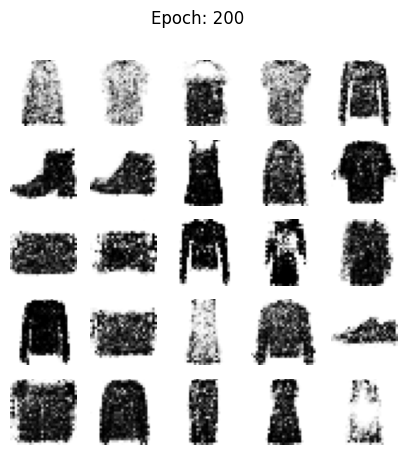

In [ ]:
from google.colab import drive
import os

# Ruta donde se encuentra el modelo guardado en tu Google Drive
model_path = 'GAN/Dense/Dense_model.h5'

# Verificar si el archivo del modelo existe en la ruta proporcionada
if os.path.exists(model_path):
    # Si el modelo existe, cargarlo desde el archivo
    loaded_model = tf.keras.models.load_model(model_path)
    print("Loaded model from Drive")
    train_gan(loaded_model, dataset, random_normal_dimensions, 'Dense_512', n_epochs=200)
else:
    # Si el modelo no existe, utilizar el modelo 'test_gan'
    print("Using test_gan")
    test_gan = dense_gan_creator(random_normal_dimensions, [256, 512], 28, [512, 256])
    train_gan(test_gan, dataset, random_normal_dimensions, 'Dense_512', n_epochs=200)

#Convolutional

## Functions and dataset


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

BATCH_SIZE = 1024
random_normal_dimensions = 32

In [ ]:
def plot_images(images, epoch, col, row = 5):
    display.clear_output(wait=False)

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(col, row))
    plt.suptitle('Epoch: ' + str(epoch))

    for index, image in enumerate(images):
        plt.subplot(row, col, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
        if index==24:
            break

In [ ]:
(x_train, _), _ = keras.datasets.fashion_mnist.load_data() # I only need the images

x_train = x_train.astype(np.float32) / 255.
x_train = x_train.reshape(-1, 28, 28, 1)

x_train_tanh = x_train * 2. - 1.

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(len(x_train))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

dataset_tanh = tf.data.Dataset.from_tensor_slices(x_train_tanh)
dataset_tanh = dataset_tanh.shuffle(len(x_train))
dataset_tanh = dataset_tanh.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

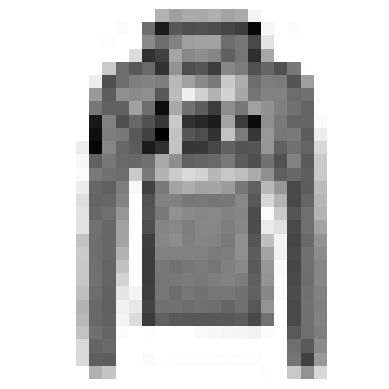

In [ ]:
# Convertir el dataset en un iterador
iterator = iter(dataset)

# Obtener una muestra de imagen
image_sample = next(iterator).numpy()

# Mostrar la imagen
plt.imshow(image_sample[0], cmap='binary')
plt.axis('off')
plt.show()

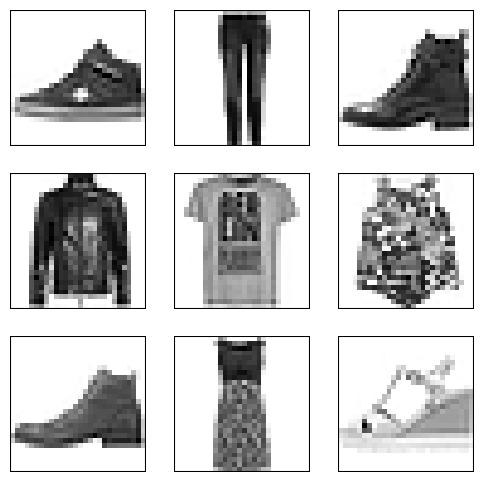

In [ ]:
import matplotlib.patches as patches

iterator = iter(dataset)
fig, axs = plt.subplots(3,3, figsize=(6,6))

for i in range(9):

    image = next(iterator)[0].numpy()
    axs[i//3, i%3].imshow(image, cmap='binary')
    axs[i//3, i%3].axis('off')

    rect = patches.Rectangle((-0.5,-0.5), 28, 28, linewidth=1.5, edgecolor='black', facecolor='none')
    axs[i//3, i%3].add_patch(rect)

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

## Generator

In [ ]:
# output should have 28x28... Then, if 2 Conv2DTransporse with stride = 2 are applied, 28/2= 14/2= 7
# 7 should be the input size

generator = keras.models.Sequential([

    keras.layers.Dense(7*7*128, input_shape=[random_normal_dimensions]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation='selu'),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation='tanh'),
])

## Noise

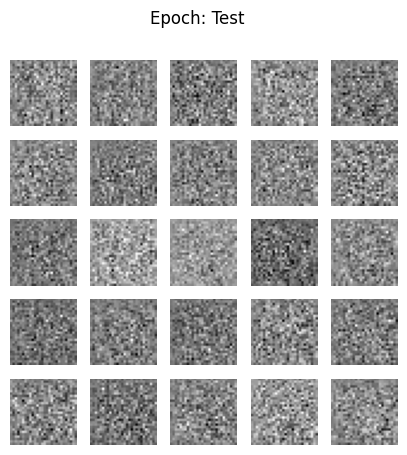

In [ ]:
test_noise = tf.random.normal([BATCH_SIZE, random_normal_dimensions]) # normal distributed error

test_image = generator(test_noise) # generation with the model

plot_images(test_image, 'Test', 5)

"\nthreshold = 0.5\n\nfor i in range(6):\n    for j in range(6):\n        pixel_value = image_noise[i, j, 0]\n        complement_value = 1 - pixel_value\n        text_color = 'white' if complement_value > threshold else 'black'\n        plt.text(j, i, f'{pixel_value:.2f}', color=text_color, fontsize=8, ha='center', va='center')"

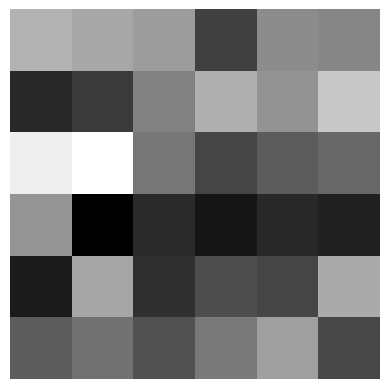

In [ ]:
test_noise_to_plot = tf.random.normal([BATCH_SIZE, 36])
image_noise = tf.reshape(test_noise_to_plot[0], (6,6,1))
plt.imshow(image_noise, cmap='gray')
plt.axis('off')

'''
threshold = 0.5

for i in range(6):
    for j in range(6):
        pixel_value = image_noise[i, j, 0]
        complement_value = 1 - pixel_value
        text_color = 'white' if complement_value > threshold else 'black'
        plt.text(j, i, f'{pixel_value:.2f}', color=text_color, fontsize=8, ha='center', va='center')'''

## Discriminator

In [ ]:
# build the discriminator model
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2),input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.2),

    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.2),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False

### GAN definition as the sequence generator + discriminator

In [ ]:
GAN = keras.models.Sequential([generator, discriminator])
GAN.compile(loss="binary_crossentropy", optimizer="rmsprop")

### Function to generate it based on number of neurons per layer

In [ ]:
def dense_gan_creator(random_normal_dimensions, gen_params, image_shape, dis_params, activation):

    inputsg =  tf.keras.layers.Input(shape=[random_normal_dimensions])


    gen = keras.layers.Dense(7*7*gen_params[0], input_shape=[random_normal_dimensions])(inputsg)
    gen = keras.layers.Reshape([7, 7, gen_params[0]])(gen)
    gen = keras.layers.BatchNormalization()(gen)

    gen = keras.layers.Conv2DTranspose(gen_params[1], kernel_size=5, strides=2, padding="same", activation='selu')(gen)
    gen = keras.layers.BatchNormalization()(gen)

    if activation == 'sigmoid':
        gen = keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation='sigmoid')(gen)

    elif activation == 'tanh':
        gen = keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation='tanh')(gen)

    else:
        print("Unknown activation")
        return None

    generator = keras.Model(inputs=inputsg, outputs=gen)

    dis = keras.layers.Conv2D(dis_params[0], kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2), input_shape=[image_shape, image_shape, 1])(gen)
    dis = keras.layers.Dropout(0.2)(dis)

    dis = keras.layers.Conv2D(dis_params[1], kernel_size=5, strides=2, padding="same", activation=keras.layers.LeakyReLU(0.2))(dis)
    dis = keras.layers.Dropout(0.2)(dis)

    dis = keras.layers.Flatten()(dis)
    dis = keras.layers.Dense(1, activation="sigmoid")(dis)

    discriminator = keras.Model(inputs=gen, outputs=dis)
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    discriminator.trainable = False

    gan = keras.models.Sequential([generator, discriminator])
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

    return gan

## Train the Model and save the model in case it crashes

In [ ]:
def train_gan(gan, dataset, random_normal_dimensions, folder, n_epochs=50):


    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:

            ### -- PHASE 1 -- ####
            batch_size = real_images.shape[0]

            # generation of fake images
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)

            # generation of train batch images and ground truth for training the discriminator
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size) # 1 for real images

            # train the discriminator on the batch
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            discriminator.trainable = False

            ### -- PHASE 2 -- ###
            # creation of the train batch with noise as input of the GAN and the desired output (1 for real)
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)

            # train of the GAN
            gan.train_on_batch(noise, generator_labels)
        path_to_model = 'GAN/Conv/Conv_model_20.h5'
        gan.save(path_to_model)
        # plot the fake images used to train the discriminator
        plot_images(fake_images, str(epoch+1), 5)
        if ((epoch+1)%20 == 0) or (epoch==0):
            plt.savefig(folder + '/' + str(epoch+1) + '.png')
        plt.show()

In [ ]:
import os
os.makedirs('/content/Conv_512_tanh', exist_ok=True)

## If a model already exists, we use the previously saved one to avoid restarting the simulation.

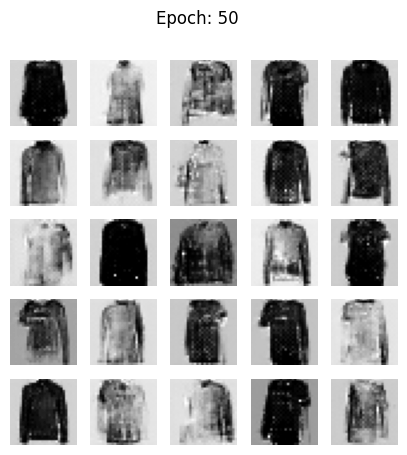

In [ ]:
from google.colab import drive
import os

# Ruta donde se encuentra el modelo guardado en tu Google Drive
model_path = 'GAN/Conv/Conv_model_20.h5'

# Verificar si el archivo del modelo existe en la ruta proporcionada
if os.path.exists(model_path):
    loaded_model = tf.keras.models.load_model(model_path)
    generator, discriminator = loaded_model.layers
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    loaded_model = keras.models.Sequential([generator, discriminator])
    loaded_model.compile(loss="binary_crossentropy", optimizer="rmsprop")

    print("Loaded model from Drive")
    train_gan(loaded_model, dataset, random_normal_dimensions, 'Conv_512_tanh', n_epochs=50)
else:
    # Si el modelo no existe, utilizar el modelo 'test_gan'
    print("Using test_gan")
    test_gan = dense_gan_creator(random_normal_dimensions, [512,256], 28, [512,256], activation='tanh')
    train_gan(test_gan, dataset, random_normal_dimensions, 'Conv_512_tanh', n_epochs=50)

(-0.5, 27.5, 27.5, -0.5)

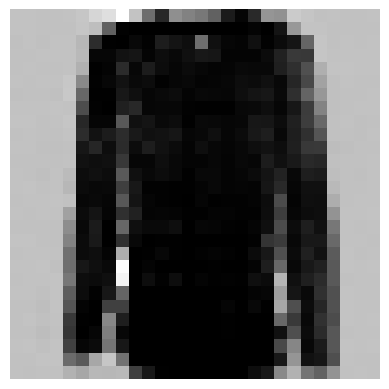

In [ ]:
generator, discriminator = test_gan.layers
noise = tf.random.normal(shape=[BATCH_SIZE, random_normal_dimensions])
fake_images = generator(noise)

plt.imshow(fake_images[0], cmap='binary')
plt.axis('off')

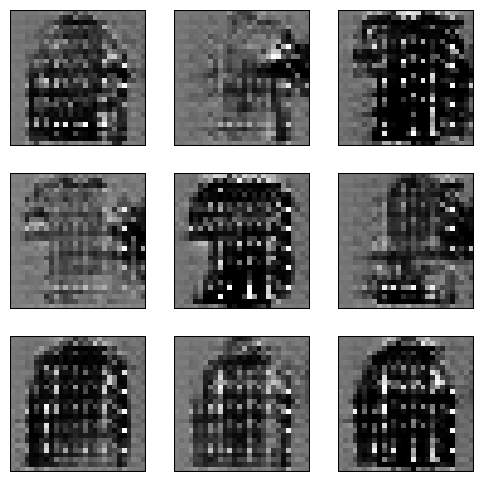

In [ ]:
import matplotlib.patches as patches

noise = tf.random.normal(shape=[9, 32])
fig, axs = plt.subplots(3,3, figsize=(6,6))

fake_images = generator(noise)

for i,image in enumerate(fake_images):
    image = tf.reshape(image, (28,28,1))
    axs[i//3, i%3].imshow(image, cmap='binary')
    axs[i//3, i%3].axis('off')

    rect = patches.Rectangle((-0.5,-0.5), 28, 28, linewidth=1.5, edgecolor='black', facecolor='none')
    axs[i//3, i%3].add_patch(rect)

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()